# AIDS data 

### Cleaning Process:
1. Import data
2. Initial column drop, sort and rename
3. Filter records for accidents caused by weather, airport, environment, etc. 
    - 3A. filter to exclude Part 121, 125, 129 records (excluding air transport carriers)
    - 3B. filter records based on cause (i.e. primary cause, secondary cause, contributing cause...)
4. Rename columns with text labels
5. Continue dropping irrelevant columns
    - Goal here is to keep columns that are relevant to one of the following:
        - Information provided through a FRAT process
        - Columns that can provide informatino to derive a severity rating
        - Information about the data (meta data) like, date, time, location, record number etc. 
6. Replace all white space entries with np.nan. 
    - There are many entries in the data set that are empty strings: '       ' and pandas does not register them as NaN resulting in the column looking like it does not have null values
7. Drop cols, impute and clean data:
    - drop columns where there is too much missing data that can not be imputed or missing records removed. 
    - impute missing data
    - clean up text and other things in each column
8. Match airport names between AIDS and Airports datasets
    - The AIDS data set has abbreviations and truncations that prevent a 1:1 match, using fuzzy matching to get best match for name in Airport dataset

## 1: import data

In [1]:
import pandas as pd
import re
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import sparse_dot_topn.sparse_dot_topn as ct
from polyfuzz.models import TFIDF
from polyfuzz import PolyFuzz

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_info_columns", 200)

In [2]:
aids_80_84 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1980_84.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
aids_85_89 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1985_89.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
aids_90_94 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1990_94.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
aids_95_99 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1995_99.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
aids_00_04 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\1. aids_2000_04.txt", sep='\t', lineterminator='\n')
aids_05_09 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\2. aids_2005_09.txt", sep='\t', lineterminator='\n')
aids_10_14 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\3. aids_2010_14.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
aids_15_19 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\4. aids_2015_19.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
aids_20_22 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\5. aids_2020_25.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")

C:\Users\htwal\AppData\Local\Temp\ipykernel_20668\3186813002.py:1: DtypeWarning: Columns (2,3,58,74,77,80) have mixed types. Specify dtype option on import or set low_memory=False.
  aids_80_84 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1980_84.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
C:\Users\htwal\AppData\Local\Temp\ipykernel_20668\3186813002.py:2: DtypeWarning: Columns (2,3,74,75,80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  aids_85_89 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1985_89.txt", sep='\t', lineterminator='\n', on_bad_lines="skip")
C:\Users\htwal\AppData\Local\Temp\ipykernel_20668\3186813002.py:3: DtypeWarning: Columns (80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  aids_90_94 = pd.read_csv(r"C:\Users\htwal\OneDrive\Documents\FAA Data Challenge\data\AIDS data\a1990_94.txt", sep='\t', lineterminator='\

## 2: rename, sort and initial irrelevant column removal

In [3]:
# create function to rename columns as their number. 
# will rename cols later
def rename_cols(df):
    ''' Standardizes column names to make them sortable.
    
    Return: dataframe with columns sorted by name in ascending 
    order ''' 
    # get list of columns
    col_names = list(df.columns)[:-1]
    # loop to remove c
    new_col_names = []
    for name in col_names:
        new_name = re.sub('[c]', '', name)
        new_col_names.append(int(new_name))
    name_dict = dict(zip(col_names, new_col_names))
    # rename cols in df
    df = df.rename(columns=name_dict)
    # return df
    return df

# create a function to sort columns in ascending order drop listed cols
def sort_and_drop_cols(df, list_to_drop):
    ''' Sorts and drops colums from the dataframe.
    
    Return: dataframe with columns sorted
    '''
    df = df.drop(columns=['end_of_record\r'])
    df = df.sort_index(axis=1)
    df = df.drop(columns=list_to_drop)
    return df

In [4]:
# concatenate all dataframes
dfs = [aids_80_84, aids_85_89, aids_90_94, aids_95_99, aids_00_04, aids_05_09, aids_10_14, aids_15_19, aids_20_22]
aids = pd.concat(dfs)

# clean up dataframe with functions above
aids = aids.drop(columns=['end_of_record\r'])
aids = rename_cols(aids)

In [5]:
aids.shape

(182912, 180)

#### NOTE:
- Initial dataframe consists of records from 1980-2022, 42 years of accident data. 
- Overall there are 182912 records and over 180 attributes. 

In [6]:
# initial dropping of columns, columns to keep 
keep = [5, 1, 2, 9, 10, 144, 145, 147, 151, 153, 157, 160, 162, 233, 234, 23, 24, 25,
        30, 31, 33, 34, 39, 11, 13, 14, 15, 16, 20, 21, 102, 106, 110, 112, 113, 114, 115, 
        117, 118, 143, 240, 241, 242, 243, 76, 250, 53, 54, 55, 56, 129, 98, 40, 44, 48, 77,  
        79, 83, 85, 87, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 148, 156, 158, 161, 163, 
        183, 191]

# filter cols:
aids = aids[keep]

In [7]:
aids.shape

(182912, 77)

In [8]:
aids[[9, 77]].tail(200)

,9,77
4491,20211104,
4492,20211109,
4493,20211027,
4494,20211027,
4495,20211028,
4496,20211028,
4497,20211104,
4498,20211104,
4499,20211104,
4500,20211031,


#### NOTE: 
- after filtering the original 180 columns 77 remain
- initial column filtering was based on looking at column definitions and determining relevance to project

## 3: Filter data

#### 3A. Filter to exclude Part 121, 129, 125

- Part 91: general aviation
- Part 135: commercial aviation
- Part 141: flight schools
- Part 121: scheduled air carriers
- Part 105: parachute operations
- Part 137: agricultural spraying
- Part 133: helo external loads
- Part 103: ultralight
- Part 125: aircraft that can carry 20 or more pax
- Part 129: foreign air carriers

In [9]:
# check the Part col (2) to look for anomolies
aids[2].unique()

array(['091', '135', '121', '129', '   ', '141', '137', '133', '105',
       '125', '127', '103', 91, 135, 121, 137, 133, 141, 105, 103, 129,
       125, 123, '49 ', 'O  ', '91-'], dtype=object)

In [10]:
# filter to exclude 121, 125, 129 records
# Change 91- to 091, 91, '   ' to 091 and O to part 91
aids[2] = aids[2].replace(['91-', '091', 'O  ', '   ', 91], '91')
aids[2] = aids[2].apply(lambda x: str(x))
print(aids[2].unique())
print('Pre-filter: ', aids.shape)
# drop records of part 121 and 129
aids = aids[(aids[2] != '121') &
            (aids[2] != '129')]

print('Post-filter: ', aids.shape)

['91' '135' '121' '129' '141' '137' '133' '105' '125' '127' '103' '123'
 '49 ']
Pre-filter:  (182912, 77)
Post-filter:  (166989, 77)


#### NOTE: 
- Filtering out part 121, 125, and 129 records resulted in dropping approximately 16,000 records from the data set

### 3B. Filter to keep records where causal factor was related to a hazard that could have been avoided during preflight planning

- Filter to keep records where causal factor was related to a hazard that could have been avoided during preflight planning
- These hazards would include the following:
    - weather related, IIMC, icing, turbulence etc
    - airport related, i.e. wet runway, narrow taxiway
    - environmental related, i.e. flight into terrain, towards hazards, powerlines, bird strike
- Causal factor columns = 77, 79, 87, 91, 161, 163, 183, 191, 
- Need to look at each column to determine criteria

In [11]:
def factor_text(col):
    ''' Function to filter text in column
    
    Filters text by removing all numeric inputs
    and adds text to a printable list
    Return: list of text
    '''
    factors = []
    for x in list(aids[col]):
        if re.match('\D', x):
            if x not in factors: 
                factors.append(x)
            else:
                pass
    for x in factors: 
        print(x)

In [12]:
# strip all whitespace
for col in aids.columns:
    if aids[col].dtypes == 'object':
        aids[col] = aids[col].str.strip()

**Col 77: primary causal factor**

In [13]:
factor_text(77)

Walk Into Propeller
Didn't Clear Engine
Improper Oper Brake/
Fail Avd Objs Or Obs
Ac Improperly Align
Other, Miscellaneous
Started Eng W/Out As
Selected Unsuitable
Cntd Flt To Fuel Low
Improper Oper Flt Cn
Collided With Obj On
Retract Gear Early O
Fail Avoid Ac/Both A
Fail Avd Collision G
Inadeq Flt/Grd Train
Undetermined
Forgot To Extend Lan
Failed To Correct Fo
Improper Proc In Tfc
Unsafe/Cond & Fail T
Improper Level Off
Land Far Down Land A
Op Gear Control, Fai
Misuse Carbht/Deic P
Miscellaneous Misuse
Attempt Operation Wi
Issued Impr Conflict
Extended Gear Too La
Misc Unsafe Acts Sta
Poor Preflight Plan
Taxi/Park Without Pr
Unsuitable Terrain S
Downwind Takeoff Or
Fail To Maintain Ade
Inadequate Insp Of A
Improper Maintenance
Cont Vfr Flight Into
Improper Inst Proc T
Fail To Use/Misuse E
Blown Over By Strong
Advanced Throt Rapid
Lost Ground Ref At N
Inadvertant Retr Lan
Fail Advise Unsafe A
Fail/Incorrect Use M
Lost Control In Adve
Misc/Pilot Unsafe Ac
Inadequate Flt/Super
Fail Fol

**Column 79: contributing factor text**

In [14]:
# Column 79: contributing factor text
aids[79] = aids[79].str.strip()

factor_text(79)

Other/Miscellaneous
Hidden Hazardous Obj
Windshield-Oil,Fog,I
Downdraft
Undetermined
Fire After Crash
Ditching
Snow Bank
Icing On Aircraft
Emergency Landing
Ice/Slush Runway
Inadequate Rwy, Taxi
Precautionary Landin
Wet Runway
Weather
Rough Water
Glassy Water
Density Altitude
Stolen Aircraft
Soft Shoulders
High Vegetation
Shifting Fuel Cargo
Bird Strike
Pilot Fatigue Or Lac
Gusty Winds
Vision Obscured By S
Blade Stall
Sabotage
Decompression, Hypox
Pax Disturbance
Rough Or Rutted Sod
Struck Animal
Loss Of Tail Rotor E
Settling W/Power


**Column 87: second contributing factor text**

In [15]:
# Column 87: second contributing factor text
aids[87] = aids[87].str.strip()

factor_text(87)

Other/Miscellaneous
Hidden Hazardous Obj
Windshield-Oil,Fog,I
Emergency Landing
Density Altitude
Icing On Aircraft
Precautionary Landin
Downdraft
Snow Bank
Weather
Undetermined
Ice/Slush Runway
Wet Runway
Glassy Water
Stolen Aircraft
Fire After Crash
Inadequate Rwy, Taxi
High Vegetation
Ditching
Soft Shoulders
Decompression, Hypox
Bird Strike
Gusty Winds
Pax Disturbance
Pilot Fatigue Or Lac
Vision Obscured By S
Rough Water
Blade Stall
Shifting Fuel Cargo
Rough Or Rutted Sod
Sabotage
Struck Animal
Settling W/Power
Loss Of Tail Rotor E


**Column 91: second supporting factor text**

In [16]:
# Column 91: second supporting factor text
aids[91] = aids[91].str.strip()

factor_text(91)

Overstressed
Undetermined
Fuel Contamination
Improper Instal - No
Other
Jammed Or Malfunctio
Worn Out-Exceeded Ti
Fouled
Leaking
Foreign Object Damag
Cracked, Split, Or B
Accumulated Mositure
Corrosion
Improperly Secured
Lack Of Lubrication
Faulty Design
Supplemental Rpt For
Ruptured Or Burst
Carburetor Icing
Improper Grade Of Fu
Plt Induced Failure/
Surface Stress (Runw
Metal Fatigue
Faulty Part (Manufac
Oil Contamination
Bogus


#### NOTE: 
- Not going to use this column for filtering purposes because criteria does not apply

**Column 161: Additional Cause Factor text**

In [17]:
aids[161] = aids[161].str.strip()

factor_text(161)

Off Side Of Runway
Rejected Takeoff
Declared Emergency
Parachute Incident
Unscheduled Landing
Fire And Rescue - Al
Unable/Unsafe To Tax
Runway Blocked
Inflight/Ground Fire
Public Complaint
Public Protection
Landed On Wrong Airp
Near Midair
Abandoned Aircraft
Descent Emergency
Fire And Rescue - Ac
Landed On Wrong Runw
Collision Avoidance
Mercy Landing
Non-Routine Pax Off-
Over Water/Into Wate
Smoke/Fumes In Cockp
Evacuation
Narcotics Involvemen
Automotive Fuel
Pax Ox Masks Extende
Hijack
Drugs, Test Or Autop
Preexisting Disease
Decompression
Fuel Dump
Ballistic Parachute
Bomb Threat


#### NOTE: 
- Not using this column for filtering because criteria does not apply

**Col 163: 2nd Additional Factor**

In [18]:
aids[163] = aids[163].str.strip()

factor_text(163)

Unscheduled Landing
Over Water/Into Wate
Fire And Rescue - Al
Smoke/Fumes In Cockp
Inflight/Ground Fire
Non-Routine Pax Off-
Runway Blocked
Descent Emergency
Declared Emergency
Landed On Wrong Airp
Unable/Unsafe To Tax
Rejected Takeoff
Public Complaint
Mercy Landing
Evacuation
Collision Avoidance
Off Side Of Runway
Abandoned Aircraft
Fire And Rescue - Ac
Narcotics Involvemen
Pax Ox Masks Extende
Hijack
Landed On Wrong Runw
Parachute Incident
Public Protection
Automotive Fuel
Drugs, Test Or Autop
Decompression
Fuel Dump
Preexisting Disease
Ballistic Parachute


#### NOTE: 
- Not using col 163 for filtering, criteria does not apply

**Col 183: Supporting Factor Text**

In [19]:
aids[183] = aids[183].str.strip()

factor_text(183)

Pilot and Ground Cre


#### NOTE: 
- Not using col 183 for filtering, criteria does not apply

**Col 191: Supporting cause factor B text**

In [20]:
aids[191] = aids[191].str.strip()

factor_text(191)

Pilot and Ground Cre


#### NOTE: 
- Not using col 191 for filtering, criteria does not apply

In [21]:
# filter to keep the following from COL 77:
# gusty winds, weather, inadequate rwy, density altitude, snow bank, ice/slush runway, icing, downdraft, hidden hazardous obj, wet runway, 
# settling with power, high vegetation, glassy water, rough water, 

# filter to keep the follwing from COL 79:
# Cont Vfr Flight Into, Fail Avd Objs Or Obs, Blown Over By Strong, Insufficient Terrain, Poor Preflight Plan, Lost Ground Ref At N,
# Unsuitable Terrain S, Improper Maintenance, Tkof Advrse Wx Crash, Windshear, Poor Preflight Plann, Collided With Obj On, 
# Fail Avd Collision G, Poor Preflight Plan/, Inadeq Flt/Grd Train, Whiteout Conditions, Incorrect Weather Fo, Collided With Ground

# filter to keep the follwing from COL 87:
# Icing On Aircraft, Weather, Snow Bank, Ice/Slush Runway, Ice/Slush Runway, Gusty Winds, Density Altitude, Wet Runway, Downdraft, High Vegetation
# Rough Or Rutted Sod, Hidden Hazardous Obj, Inadequate Rwy, Taxi, Rough Water

print('Pre-filter: ', aids.shape)

aids = aids[(aids[77] == 'Struck Birds In Flig') |
            (aids[77] == 'Cont Vfr Flight Into') |
            (aids[77] == 'Fail Avd Objs Or Obs') |
            (aids[77] == 'Blown Over By Strong') |
            (aids[77] == 'Insufficient Terrain') |
            (aids[77] == 'Poor Preflight Plan') |
            (aids[77] == 'Lost Ground Ref At N') |
            (aids[77] == 'Unsuitable Terrain S') |
            (aids[77] == 'Tkof Advrse Wx Crash') |
            (aids[77] == 'Windshear') |
            (aids[77] == 'Poor Preflight Plann') |
            (aids[77] == 'Collided With Obj On') |
            (aids[77] == 'Fail Avd Collision G') |
            (aids[77] == 'Poor Preflight Plan/') |
            (aids[77] == 'Inadeq Flt/Grd Train') |
            (aids[77] == 'Whiteout Conditions') |
            (aids[77] == 'Incorrect Weather Fo') |
            (aids[77] == 'Collided With Ground') |
            (aids[77] == 'Struck Animal') |
            (aids[77] == 'Lost Control In Adve') |
            (aids[77] == 'Downwind Takeoff Or') |
            (aids[77] == 'Lost On/Off Course V') |
            (aids[77] == 'Landed Short') |
            (aids[77] == 'Operation Below Vmc') |
            (aids[77] == 'Inadeq/Imp Pf Prep/P') |
            (aids[77] == 'Incomplete Weather R') |
            (aids[77] == 'Fail To Avd Tv Or Ra') |
            (aids[77] == 'Landed On Wrong Airp') |
            (aids[79] == 'Gusty Winds') |
            (aids[79] == 'Weather') |
            (aids[79] == 'Inadequate Rwy, Taxi') |
            (aids[79] == 'Density Altitude') |
            (aids[79] == 'Snow Bank') |
            (aids[79] == 'Ice/Slush Runway') |
            (aids[79] == 'Icing On Aircraft') |
            (aids[79] == 'Downdraft') |
            (aids[79] == 'Wet Runway') |
            (aids[79] == 'Hidden Hazardous Obj') |
            (aids[79] == 'Rough Or Rutted Sod') |
            (aids[79] == 'High Vegetation') |
            (aids[79] == 'Struck Animal') |
            (aids[79] == 'Ditching') |
            (aids[79] == 'Bird Strike') |
            (aids[87] == 'Gusty Winds') |
            (aids[87] == 'Weather') |
            (aids[87] == 'Inadequate Rwy, Taxi') |
            (aids[87] == 'Density Altitude') |
            (aids[87] == 'Snow Bank') |
            (aids[87] == 'Ice/Slush Runway') |
            (aids[87] == 'Icing On Aircraft') |
            (aids[87] == 'Downdraft') |
            (aids[87] == 'Wet Runway') |
            (aids[87] == 'Rough Or Rutted Sod') |
            (aids[87] == 'Settling W/Power') |
            (aids[87] == 'High Vegetation') |
            (aids[87] == 'Glassy Water') |
            (aids[87] == 'Icing On Aircraft') |
            (aids[87] == 'Weather') |
            (aids[87] == 'Snow Bank') |
            (aids[87] == 'Ice/Slush Runway') |
            (aids[87] == 'Gusty Winds') |
            (aids[87] == 'Density Altitude') |
            (aids[87] == 'Wet Runway') |
            (aids[87] == 'Downdraft') |
            (aids[87] == 'High Vegetation') |
            (aids[87] == 'Rough Or Rutted Sod') |
            (aids[87] == 'Hidden Hazardous Obj') |
            (aids[87] == 'Inadequate Rwy, Taxi') |
            (aids[79] == 'Bird Strike') |
            (aids[79] == 'Struck Animal')]

print('Post-filter: ', aids.shape)

Pre-filter:  (166989, 77)
Post-filter:  (38277, 77)


#### NOTE: 
- Filtering the data frame for causal factors related to hazards or events that could have been avoided during preflight planning resulted in the following:
    - Original record count: 166989
    - Post-filter record count: 38277
    - Delta: 127,277
- This is a big delta but it makes sense because weather and environmental related accidents are a small fraction of overall accidents

#### 4. Rename columns with text labels

In [22]:
# names are derived from the 'AIDS report_col_names.txt' file
names = {5: 'control_number', 1: 'event_type', 2: 'far_part_num', 9: 'accident_date', 10: 'accident_time', 144: 'aircraft_design_code', 
         145: 'weight_class_code', 147: 'wing_info', 151: 'num_engines', 153: 'horsepower_750', 157: 'ldg_gear', 160: 'additional_cause_factor', 
         162: 'sec_add_cause_factor', 233: 'fatal_pilot', 234: 'fatal_second_pilot', 23: 'aircraft_make', 24: 'aircraft_model', 
         25: 'aircraft_group', 30: 'airworthiness_class', 31: 'airframe_hrs', 33: 'wing_lo_hi', 34: 'engine_make', 39: 'engine_type', 
         11: 'accident_region', 13: 'accident_state', 14: 'accident_city', 15: 'airport_name', 16: 'runway_number', 20: 'latitude', 21: 'longitude',
         102: 'primary_flight_type_code', 106: 'primary_flight_condition', 110: 'light_condition', 112: 'sky_condition', 113: 'cloud_ceiling', 
         114: 'visibility', 115: 'visibility_restriction', 117: 'runway_condition', 118: 'braking_condition', 143: 'airport_id', 
         240: 'wind_direction', 241: 'wind_speed_mph', 242: 'gust_indicator_flag', 243: 'gust_speed_mph', 76: 'total_fatalities', 
         250: 'injuries', 53: 'flt_hrs_in_model', 54: '90_day_hrs_model', 55: '90_day_hrs', 56: 'total_pilot_hrs', 129: 'ntsb_file_num', 
         98: 'damage_code', 40: 'pilot_certificate', 44: 'pilot_rating', 48: 'pilot_qual', 77: 'primary_cause', 79: 'contributing_factor', 
         83: 'supporting_factor', 85: 'second_cause_factor', 87: 'second_contributing_factor', 91: 'second_supporting_factor', 93: 'accident_type',
         95: 'flight_phase', 97: 'damage', 99: 'general_cause', 101: 'primary_flight_type_txt', 103: 'second_flight_type', 105: 'primary_flight_condition_txt',
         107: 'secondary_flying_condition_txt', 109: 'light_condition_text', 148: 'wing_info_txt', 156: 'type_of_engine', 158: 'ldg_gear_type', 
         161: 'additional_causal_factor', 163: '2nd_additional_causal_factor', 183: 'supporting_factor_txt', 191: 'supporting_cause_factor_B_txt'}

In [23]:
aids = aids.rename(columns=names)

In [24]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38277 entries, 4 to 13716
Data columns (total 77 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   control_number                  38277 non-null  object 
 1   event_type                      38277 non-null  object 
 2   far_part_num                    38277 non-null  object 
 3   accident_date                   38277 non-null  int64  
 4   accident_time                   38277 non-null  object 
 5   aircraft_design_code            38277 non-null  object 
 6   weight_class_code               38277 non-null  object 
 7   wing_info                       38277 non-null  object 
 8   num_engines                     37844 non-null  float64
 9   horsepower_750                  38277 non-null  object 
 10  ldg_gear                        38277 non-null  object 
 11  additional_cause_factor         38277 non-null  object 
 12  sec_add_cause_factor            

### 5. Continue dropping irrelevant columns based on FRAT tool

#### NOTE: 
- There are many columns in the set that are duplicates: 
    - for example, there will be one textual column, then a sister column where all the values are encoded with a letter
    - need to drop all the encoded columns because there is no formal key for the encoding
    - the following code blocks explore all these columns and annotate which columns to drop in a comment at the end.  

In [25]:
# there are three columns related to wing information
print(aids['wing_info'].unique())
print(aids['wing_lo_hi'].unique())
print(aids['wing_info_txt'].unique())

# drop 'wing_info' and 'wing_lo_hi'

['L' 'H' 'M' '' 'G' 'K' 'Q' 'B' 'D' 'X' 'W' 'S' 'P' 'F']
['L' 'H' 'M' '' 'G' 'K' 'Q' 'B' 'D' 'O' 'J' '1']
['MONOPLANE-LOW WING' 'MONOPLANE-HIGH WING/PARA WING' 'MONOPLANE-MID WING'
 '' 'ROTARY WING-HELI/GYROCOPTER' 'KITE/SAILWING'
 'MULTI WING-BI/TRIPLANE,ETC' 'LIGHTR THAN AIR/BAL/BLP/DIR'
 'DELTA WING/SWING WING' 'OTHER' 'WEIGHT SHIFT CONTROL'
 'STOL/VTOL/TILT/WING' 'PARACHUTE-LOW PERFORMANCE' 'FLEXIBLE OR SEMIRIGID']


In [26]:
print(aids['engine_type'].unique())
print(aids['type_of_engine'].unique())

# drop 'engine_type'

['' 'O' 'R' 'T' 'U' 'F' 'J' 'I' 'V' 'X' '150L']
['' 'RECIPROCATING-OPPOSED' 'RECIPROCATING-RADIAL' 'TURBOPROP'
 'TURBOSHAFT' 'TURBOFAN/TURBOJET BYPASS' 'TURBOJET' 'RECIPROCATING-INLINE'
 'RECIPROCATING-VEE' 'OTHER']


In [27]:
print(aids['primary_flight_type_code'].unique())
print(aids['primary_flight_type_txt'].unique())

# drop 'primary_flight_type_code'

['1' '2' '5' '4' '8' '3' 'B' 'A' 'J' '6' '7' 'H' 'C' '9' 'G' 'D' 'F' 'E'
 nan]
['Personal' 'Business' 'Air Taxi (Non-Schedu' 'Instruction' 'Other'
 'Executive' 'A/T Com (Sched 5/Mor' 'Air Taxi (Sched-Not'
 'Illegal Drug, Stolen' 'Aerial Applicator' 'Industrial/Special'
 'All Cargo Carriers' 'Scheduled Air Carrie' 'For Hire'
 'Supplemental Or Comm' 'Air Taxi Oper-Large' 'Travel Clubs' '']


In [28]:
print(aids['primary_flight_condition'].unique())
print(aids['primary_flight_condition_txt'].unique())

# drop 'primary_flight_condition'

['B' 'A' 'C' nan]
['VFR' 'IFR' 'Unknown' '']


In [29]:
print(aids['light_condition'].unique())
print(aids['light_condition_text'].unique())

# drop 'light_condition'

[ 1.  2. nan  3.  4.  5.]
['Day' 'Night' '' 'Dawn' 'Dusk' 'Unknown']


In [30]:
print(aids['damage'].unique())
print(aids['damage_code'].unique())

# drop 'damage'

['' 'Unknown']
['M' 'S' 'D' '' 'U' 'N']


In [31]:
print(aids['ldg_gear'].unique())
print(aids['ldg_gear_type'].unique())

# drop 'ldg_gear'

['' 'TR' 'CV' 'T' 'J' 'O' '0' 'R']
['' 'Wheeled-Tricycle' 'Wheeled-Conventional' 'Historical Small Aircraft'
 'Historical Large Aircraft' 'Historical Rotocraft' 'Historical Unknown'
 'Historical Amateur Built']


In [32]:
aids = aids.drop(['wing_info', 'wing_lo_hi', 'engine_type', 'primary_flight_type_code', 'primary_flight_condition',
                  'light_condition', 'damage', 'ldg_gear'], axis=1)

In [33]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38277 entries, 4 to 13716
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   control_number                  38277 non-null  object 
 1   event_type                      38277 non-null  object 
 2   far_part_num                    38277 non-null  object 
 3   accident_date                   38277 non-null  int64  
 4   accident_time                   38277 non-null  object 
 5   aircraft_design_code            38277 non-null  object 
 6   weight_class_code               38277 non-null  object 
 7   num_engines                     37844 non-null  float64
 8   horsepower_750                  38277 non-null  object 
 9   additional_cause_factor         38277 non-null  object 
 10  sec_add_cause_factor            38277 non-null  object 
 11  fatal_pilot                     38277 non-null  object 
 12  fatal_second_pilot              

#### NOTE: 
- Dropped 8 columns, went from 77 columns to 69 columns

### 6: Replace white space in all columns with NaN

In [34]:
# use regex for whitespace to fill with np.nan
aids = aids.replace(r'^\s*$', np.nan, regex=True)

### 7. Drop columns that have over 30% NaN values or can not impute, clean each column

In [35]:
# these columns are dropped because there is far too much missing data
drop_nan_col = ['aircraft_design_code', 'additional_cause_factor', 'sec_add_cause_factor', 'fatal_second_pilot', 'airworthiness_class',
                'braking_condition', '90_day_hrs_model', 'ntsb_file_num', 'pilot_qual', 'supporting_factor', 
                'second_cause_factor', 'second_contributing_factor', 'second_supporting_factor', 'additional_causal_factor',
                '2nd_additional_causal_factor', 'supporting_factor_txt', 'supporting_cause_factor_B_txt']


aids = aids.drop(drop_nan_col, axis=1)

In [36]:
# drop records that have nan time
aids = aids.dropna(subset=['accident_time'])
aids.shape

(37885, 52)

In [37]:
# check to see if weight class code is usable information
print(aids['weight_class_code'].unique())

# fill nan in weight class code with the mode
print(aids['weight_class_code'].mode())

# fill with 1
aids['weight_class_code'] = aids['weight_class_code'].fillna(1)

['1' '2' nan]
0    1
Name: weight_class_code, dtype: object


- **Weight class** seems to be a binary input where the weight is above or below a certain value but not certain what the value is

In [38]:
# check num engines column
aids['num_engines'].unique()
print(aids['num_engines'].mode())
# fill with mode
aids['num_engines'] = aids['num_engines'].fillna(1.0)

0    1.0
Name: num_engines, dtype: float64


In [39]:
# explore the horsepower_750 col
aids['horsepower_750'].unique()
print(aids['horsepower_750'].value_counts())
# col uses 3 for True and 4 for False
# replace 3 for 1 and 4 for 2. then replace nan with mode
# dropping horsepower because there is too many missing values
aids = aids.drop('horsepower_750', axis=1)

3    21142
4      919
Name: horsepower_750, dtype: int64


In [40]:
# only need the total fatalities column
aids = aids.drop(['fatal_pilot'], axis=1)

In [41]:
# remove nan records from the following columns:
aids = aids.dropna(subset=['aircraft_make', 'aircraft_model', 'aircraft_group'])

array([[<AxesSubplot:title={'center':'airframe_hrs'}>]], dtype=object)

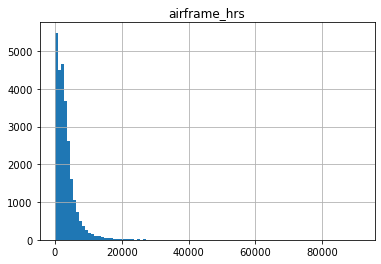

In [42]:
# will impute airframe hours, check distribution:
aids.hist('airframe_hrs', bins=100)

In [43]:
# impute airframe hours with median
airframe_median = aids['airframe_hrs'].median()
aids.loc[:, 'airframe_hrs'] = aids.loc[:, 'airframe_hrs'].fillna(airframe_median)

In [44]:
aids['engine_make'].unique()

array([nan, 'LYC', 'PWA', 'CONT', 'ARSRCH', 'GLADEN', 'TMECA', 'GE',
       'ALLSN', 'WRIGHT', 'AMTRVW', 'ONAN', 'JACOBS', 'FRNKLN', 'FCD',
       'AMTRLC', 'JACOBP', 'RROYCE', 'AMTRMC', 'AMTRRW', 'AMTR', 'WARNER',
       'ROTAX', 'DHAVXX', 'IAME', 'LIMBAH', 'MNASCO', 'WSK', 'PCKARD',
       'GARRTT', 'ENMA', 'WALTER', 'ALIDSG', 'WILINT', 'FORD', 'VEDENY',
       'AMTRRM', 'AMES', 'ZMDB', 'PWC', 'HNYWL'], dtype=object)

In [45]:
# replace engine make NaN with Unknown
aids['engine_make'] = aids['engine_make'].replace(np.nan, 'Unknown')

In [46]:
# replace nan in city and state with unknown
aids[['accident_state', 'accident_city']] = aids[['accident_state', 'accident_city']].replace(np.nan, 'Unknown')

In [47]:
# replace nan in airport name with "none"
aids['airport_name'] = aids['airport_name'].replace(np.nan, 'none')
aids['airport_name'].unique()

array(['ANDRAU', 'MUNI', 'PRIVATE', ..., 'CENTRAL NEBRASKA RGNL',
       'JASPER COUNTY-BELL FIELD', 'HAZELTON MUNI'], dtype=object)

In [48]:
# runway number is specific to accidents that occur on a runway. 
# if nan that means accident was not associated with runway so change to 0
def replace_rwy(num):
    if num > 36:
        num = 0
    elif num == np.nan:
        num = 0
    return num

# remove the R/L designator, change any 
aids['runway_number'] = aids['runway_number'].replace(r'[\D]', '', regex=True).replace('', np.nan).fillna(0).astype('int').apply(replace_rwy)

In [49]:
aids['sky_condition'].unique()

array(['SCAT', 'CLER', 'OCST', nan, 'BRKN', 'OBSC'], dtype=object)

In [50]:
# impute flight hours in model with the median
flt_hr_model = aids['flt_hrs_in_model'].median()
aids['flt_hrs_in_model'] = aids['flt_hrs_in_model'].fillna(flt_hr_model)

In [51]:
# impute 90 day hours with medial also
ninety_day_hrs_median = aids['90_day_hrs'].median()
aids['90_day_hrs'] = aids['90_day_hrs'].fillna(ninety_day_hrs_median)

In [52]:
# impute total hours with medial also
tot_hrs_median = aids['total_pilot_hrs'].median()
aids['total_pilot_hrs'] = aids['total_pilot_hrs'].fillna(tot_hrs_median)

In [53]:
# damage code
aids['damage_code'].value_counts()
aids['damage_code'] = aids['damage_code'].fillna('S')

In [54]:
# check pilot certificate
aids['pilot_certificate'].value_counts()
# impute nan with most common category
aids['pilot_certificate'] = aids['pilot_certificate'].fillna('PRIVATE PILOT')

In [55]:
# check pilot rating also
aids['pilot_rating'].value_counts()
aids['pilot_rating'] = aids['pilot_rating'].replace('NO RATING (OR STUDEN', 'NO RATING').fillna('NO RATING')

In [56]:
# drop the nan row in the following cols:
aids = aids.dropna(subset=['primary_cause', 'flight_phase', 'general_cause', 'primary_flight_type_txt', 
                           'second_flight_type', 'primary_flight_condition_txt', 'secondary_flying_condition_txt',
                           'wing_info_txt',])
  

In [57]:
# fill nan in contributing factor col
aids['contributing_factor'].value_counts()
# impute with 'other'
aids['contributing_factor'] = aids['contributing_factor'].fillna('Other/Miscellaneous')

In [58]:
aids['light_condition_text'].value_counts()
aids['accident_time'] = aids['accident_time'].replace(['!$))', '!!)&'], '1200').astype(int)

# use this to fill nan vals in the lighting condition col
def impute_light(time):
    if (time >= 500) & (time <= 700):
        text = 'Dawn'
    elif (time >= 632) & (time <= 1700):
        text = 'Day'
    elif (time >= 1701) & (time <= 1900):
        text = 'Dusk'
    elif (time >= 1901) | (time <= 459):
        text = 'Night'
    return text

In [59]:
# creat a list of times and lighting conditions
time_light = list(zip(aids['accident_time'], aids['light_condition_text']))

# run the function to impute lighting condition as a new list
new_light = []
for x, y in time_light:
    if (y == np.nan) or (y == 'Unknown'):
        lights = impute_light(x)
        y = lights
        new_light.append(y)
    else: 
        new_light.append(y)

In [60]:
# add imputed lighting conditions to the column in the data frame
aids['light_condition_text'] = new_light

In [61]:
aids['light_condition_text'].value_counts()

Day      29363
Night     5653
Dusk      1169
Dawn       306
Name: light_condition_text, dtype: int64

In [62]:
# drop engine type and landing gear type because there are too many to impute
aids = aids.drop(['type_of_engine', 'ldg_gear_type'], axis=1)

In [63]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37074 entries, 4 to 13497
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   control_number                  37074 non-null  object 
 1   event_type                      37074 non-null  object 
 2   far_part_num                    37074 non-null  object 
 3   accident_date                   37074 non-null  int64  
 4   accident_time                   37074 non-null  int32  
 5   weight_class_code               37074 non-null  object 
 6   num_engines                     37074 non-null  float64
 7   aircraft_make                   37074 non-null  object 
 8   aircraft_model                  37074 non-null  object 
 9   aircraft_group                  37074 non-null  object 
 10  airframe_hrs                    37074 non-null  float64
 11  engine_make                     37074 non-null  object 
 12  accident_region                 

## 8. match airport names between AIDS and Airports data sets
- necessary to derive additional information as well as weather


### 8A. Read in Airport data

In [64]:
airports = pd.read_csv('us-airports.csv')

In [65]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20347 entries, 0 to 20346
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WKT         20347 non-null  object 
 1   LOCID       20347 non-null  object 
 2   SITE_NO     20347 non-null  object 
 3   FULLNAME    20347 non-null  object 
 4   FAA_ST      20326 non-null  object 
 5   LAN_FA_TY   20347 non-null  object 
 6   EFF_DATE    20347 non-null  object 
 7   FAA_REGION  20326 non-null  object 
 8   FAA_DISTRI  20347 non-null  object 
 9   STATE_NAME  20347 non-null  object 
 10  ST_POSTAL   20347 non-null  object 
 11  STFIPS      20347 non-null  int64  
 12  COUNTY_NAM  20347 non-null  object 
 13  COUNTY_ST   20347 non-null  object 
 14  CITY_NAME   20347 non-null  object 
 15  OWNER_TYPE  20347 non-null  object 
 16  FAC_USE     20347 non-null  object 
 17  FAC_CYSTZP  20014 non-null  object 
 18  ELEV        20347 non-null  int64  
 19  AERO_CHART  20220 non-nul

In [66]:
# check to see if the airport names are unique
names = airports['FULLNAME'].value_counts()
names = names.reset_index()
names[names['FULLNAME'] > 1]
# names are not unique so will have to take some steps to make them as unique as possible

,index,FULLNAME
0,MEMORIAL HOSPITAL,20
1,SMITH,14
2,JOHNSON,14
3,HILLTOP,12
4,SMITH FIELD,11
...,...,...
998,KRAMER,2
999,KELLER,2
1000,CASTLE,2
1001,LINCOLN MUNI,2


In [67]:
# have to change the abbreviated state id in the aids df to full name
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [68]:
# imputing the full name into the aids df for states
states = []
for x in aids['accident_state']:
    if x in abbrev_to_us_state:
        states.append(abbrev_to_us_state[x])
    else:
        states.append('none')
print(len(states))
aids['accident_state'] = states

37074


In [69]:
# trying to create unique 
aids['apt_mash'] = aids['airport_name'] + ' ' + aids['accident_state'] + ' ' + aids['accident_city']
airports['apt_mash'] = airports['FULLNAME'] + ' ' + airports['STATE_NAME'] + ' ' + airports['CITY_NAME']

In [70]:
# text cleaning for the fuzzy matching. 
airports['apt_mash'] = airports['apt_mash'].str.lower()

# aids data needs many abbreviations removed to make them as close as possible to airports df
aids['apt_mash'] = aids['apt_mash'].str.replace(
    r'(\sARPK)$', '', regex=True, case=False).str.replace(
    r'(\sARPT)$', '', regex=True, case=False).str.replace(
    r'(\sMUNI)$', '', regex=True, case=False).str.replace(
    r'(\sINTL)', '', regex=True, case=False).str.replace(
    r'(\sRGNL)', '', regex=True, case=False).str.replace(
    r'(\sAIRPARK)', '', regex=True, case=False).str.replace(
    r'(\sREGIONAL)', '', regex=True, case=False).str.replace(
    r'(\sAIRPORT)', '', regex=True, case=False).str.replace(
    r'(\sCOUNTY)', '', regex=True, case=False).str.replace(
    r'(\sINTERNATIONAL)', '', regex=True, case=False).str.lower()

In [71]:
# setting up the fuzzy matching model, only keep 90% matchs
tfidf = TFIDF(n_gram_range=(3, 3), min_similarity=0.8,model_id="TF-IDF")
model = PolyFuzz(tfidf).match(list(aids['apt_mash']), list(airports['apt_mash']))

In [72]:
# creating the table of results
matches = model.get_matches()
matches = matches[['From', 'To']]

In [73]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37074 entries, 0 to 37073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   From    37074 non-null  object
 1   To      24546 non-null  object
dtypes: object(2)
memory usage: 579.4+ KB


In [74]:
# need to put matches in a dictionary and one for one impute the matches into the aids dataframe
match_dict = dict(zip(matches['From'], matches['To']))

In [75]:
def match_col(x):
    match_column = []
    if x in match_dict:
        match_column.append(str(match_dict[x]))
    return match_column

In [76]:
aids['matches'] = aids['apt_mash'].apply(match_col)

In [77]:
# check the results
len(aids['matches'])

37074

In [78]:
aids[['airport_name', 'apt_mash', 'matches']].sample(15)

,airport_name,apt_mash,matches
2465,PRIVATE,private texas luling,[None]
25302,DUTCHES CO,dutches co new york lagrange,[None]
7212,SANTA BARBARA MUNI,santa barbara muni california santa barbara,[santa barbara muni california santa barbara]
27789,MUNI,muni arkansas ft smith,[fort smith rgnl arkansas fort smith]
12534,DECATUR,decatur illinois decatur,[decatur illinois decatur]
13106,DANBURY MUNI,danbury muni connecticut danbury,[danbury muni connecticut danbury]
18720,SUSANVILLE MUNI ARPT,susanville muni arpt california susanville,[susanville muni california susanville]
21391,PRIVATE,private georgia oakpark,[None]
21269,CLOVER,clover texas friendswood,[None]
1788,PASO ROBLES MUNI,paso robles muni california paso robles,[paso robles muni california paso robles]


In [79]:
# clean up the strings in this col
aids['matches'] = aids['matches'].astype(str).str.replace(r'[\[\]\']', '', regex=True)
aids['matches'].unique()

array(['None', 'st joseph hospital - elgin illinois elgin',
       'beatty nevada beatty', ...,
       'frazier lake airpark california hollister',
       'inshallah intl oregon seneca',
       'northwest alabama rgnl alabama muscle shoals'], dtype=object)

In [80]:
# check to see how many matches there are compared to the original data frame
print('AIDS data record count:', len(aids))
count1 = 0 
for x in aids['airport_name']:
    if x != 'none':
        count1 += 1
print('Total records where accident associated with airport:', count1)
count3 = 0
for x in aids['matches']:
    if x != 'None':
        count3 += 1
print(f'Total positive matches: {count3}')
print('Delta: airports that did not get matched ', (count1 - count3))

AIDS data record count: 37074
Total records where accident associated with airport: 24756
Total positive matches: 24546
Delta: airports that did not get matched  210


In [81]:
# create a column 'accident_at_apt' where we flag if accident occured at airport or not
apt_accident = []
for x in aids['airport_name']:
    if x != 'none':
        apt_accident.append(1)
    else: 
        apt_accident.append(0)
aids['accident_at_apt'] = apt_accident

### goal is to conduct a join airports data to aids data on ICAO
1. Prep aids:
    - dataframe where all icao is null
    - filter for airport name is true
2. create a dictionary with airports data
    - key in dict will be icao
    - values will be fuzzy match airport name, city
3. fill the null icao in aids 
    - create function to fill icao if the airport name is in the dict

In [82]:
# 1. prep a data frame with airport_names but missing ICAO codes
aids_null_icao = aids[aids['airport_id'].isna()]
aids_null_icao.shape

(21217, 51)

In [83]:
# 2. create dictionary with airports data
# key: icao
# values: airport name/city i.e. 'apt_mash'
vals = dict(zip(airports['apt_mash'], airports['LOCID']))

In [84]:
# 3. create list of ICAOs to backfill the aids data
icao_fills = []
for x in aids_null_icao['matches']:
    if x in vals:
        icao_fills.append(vals[x])
    else:
        icao_fills.append(np.nan)

In [85]:
aids_null_icao.loc[:, 'airport_id'] = icao_fills

C:\Users\htwal\AppData\Local\Temp\ipykernel_20668\3520718752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aids_null_icao.loc[:, 'airport_id'] = icao_fills


In [86]:
# drop the na records from aids where airport id is null 
aids = aids.dropna(subset='airport_id')

# concat the two data frames
aids = pd.concat([aids, aids_null_icao])

In [87]:
aids.shape

(37074, 51)

In [88]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37074 entries, 2109 to 13315
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   control_number                  37074 non-null  object 
 1   event_type                      37074 non-null  object 
 2   far_part_num                    37074 non-null  object 
 3   accident_date                   37074 non-null  int64  
 4   accident_time                   37074 non-null  int32  
 5   weight_class_code               37074 non-null  object 
 6   num_engines                     37074 non-null  float64
 7   aircraft_make                   37074 non-null  object 
 8   aircraft_model                  37074 non-null  object 
 9   aircraft_group                  37074 non-null  object 
 10  airframe_hrs                    37074 non-null  float64
 11  engine_make                     37074 non-null  object 
 12  accident_region              

**Note:**
- The model does a good job of matching airport names
- next, add the 'TO' column to the aids dataframe then do a inner join with airports ON the TO col

In [89]:
# choose columns to join from airports data set
apts_join = airports[['LOCID', 'FULLNAME', 'COUNTY_NAM', 'OWNER_TYPE', 'ELEV', 'CNTL_TWR', 'LATITUDE', 'LONGITUDE']]

# rename some cols to differ from AIDS cols
apts_join = apts_join.rename(columns={'LATITUDE':'LATITUDE_APT', 'LONGITUDE':'LONGITUDE_APT', 'OWNER_TYPE':'APT_OWNER_TYPE',
                                      'FULLNAME':'matches', 'LOCID':'ICAO', 'COUNTY_NAM':'COUNTY_NAME_APT'})

In [90]:
# now we can join the airports dataset on the aids data set using the 'matches' column as the key

aids_apt = pd.merge(aids, apts_join, left_on='airport_id', right_on='ICAO', how='left')

In [91]:
aids_apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37074 entries, 0 to 37073
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   control_number                  37074 non-null  object 
 1   event_type                      37074 non-null  object 
 2   far_part_num                    37074 non-null  object 
 3   accident_date                   37074 non-null  int64  
 4   accident_time                   37074 non-null  int32  
 5   weight_class_code               37074 non-null  object 
 6   num_engines                     37074 non-null  float64
 7   aircraft_make                   37074 non-null  object 
 8   aircraft_model                  37074 non-null  object 
 9   aircraft_group                  37074 non-null  object 
 10  airframe_hrs                    37074 non-null  float64
 11  engine_make                     37074 non-null  object 
 12  accident_region                 

In [92]:
stations = aids_apt['airport_id'].tolist()
date_apt = aids_apt['accident_date'].to_list()
time_apt = aids_apt['accident_time'].to_list()

In [93]:
# create a list and write to txt file to use for scraping weather data
stations2 = []
for station in stations:
    if station is not np.nan:
        stations2.append(station)

fix_time = []
for x in time_apt:
    x = str(x)
    if len(x) == 4:
        fix_time.append(x[0:2])
    else:
        x = '0' + x[0]
        fix_time.append(x)
        
dt_accident = list(zip(date_apt, fix_time))
date_time_accident = []
for x in dt_accident:
    date_time_accident.append(str(x[0]) + str(x[1]))
    
station_datetime = list(zip(stations2, date_time_accident))

In [94]:
with open(r'stations', 'w') as fp:
    for x in station_datetime:
        fp.write(f"{x}\n")

## 9. Join weather data to AIDS data

In [95]:
# read in weather text file
with open(r'C:\Users\htwal\PycharmProjects\FAA_DC\wx_file.txt', 'r') as f:
    wx_list = []
    for row in f:
        wx_list.append(row)

In [96]:
# drop out all lines to only keep weather lines
clean_wx = []
for line in wx_list:
    match1 = re.match('#DEBUG', line)
    match2 = re.match('station', line)
    if not match1 and not match2:
        clean_wx.append([line])
    

In [97]:
# all lines are read in as solid string, need to split them up
clean_wx_2 = []
for line in clean_wx:
    broken_string = line[0].split(',')
    clean_wx_2.append(broken_string)


In [98]:
# need to fix the date time column
for x in clean_wx_2:
    date = datetime.strptime(x[1], '%Y-%m-%d %H:%M')
    x[1] = date.strftime('%Y%m%d%H')


In [99]:
# now adjust the date time in dataframe to match format of list
def fix_time(x):
    x = str(x)
    if len(x) < 4:
        x = '0' + x
    return x

aids_apt['accident_time'] = aids_apt['accident_time'].apply(fix_time) 
aids_apt['accident_date_time'] = aids_apt['accident_date'].astype(str) + aids_apt['accident_time'].astype(str)
    

In [100]:
aids_apt['accident_date_time'] = aids_apt['accident_date_time'].str.replace(r'(?<=\d{10})\d{2}', '')

In [101]:
# create the key in aids_apt
aids_apt['key'] = aids_apt['ICAO'] + aids_apt['accident_date_time']

In [102]:
# create a join key bu combining airport id to date time
for x in clean_wx_2:
    key = x[0] + x[1]
    x.append(key)

In [103]:
# put the clean_wx_2 into data frame:
wx = pd.DataFrame(clean_wx_2, columns=['station','valid','lon','lat','tmpf','dwpf','relh','drct','sknt',
                                       'p01i','alti','mslp','vsby','gust','skyc1','skyc2','skyc3','skyc4',
                                       'skyl1','skyl2','skyl3','skyl4','wxcodes','ice_accretion_1hr',
                                       'ice_accretion_3hr','ice_accretion_6hr','peak_wind_gust',
                                       'peak_wind_drct','peak_wind_time','feel','metar','snowdepth', 'key'])

In [104]:
wx.shape

(257839, 33)

In [105]:
wx = wx.drop_duplicates()
wx = wx.drop_duplicates(subset='key')
wx.shape

(210392, 33)

In [106]:
wx = wx.replace('M', np.nan).replace('   ', np.nan)

In [107]:
wx_col = list(wx.columns)
wx_names = ['wx_' + x for x in wx_col if x != 'key']
wx_rename = dict(zip(wx_col, wx_names))
wx = wx.rename(wx_rename, axis=1)

In [108]:
aids_apt['key']

0                  NaN
1        PIE1980051912
2        RDU1981022217
3                  NaN
4        MKK1981012809
             ...      
37069    SOW2008053011
37070    DUT2008040916
37071    30M2008081317
37072    87I2008082215
37073              NaN
Name: key, Length: 37074, dtype: object

In [109]:
# join data_wx
aids_apt_wx = aids_apt.merge(wx, on='key', how='left')

In [111]:
# final column drop
aids_apt_wx = aids_apt_wx.drop(['matches_x', 'matches_y', 'apt_mash', 'airport_id', 'key', 'wx_p01i', 'wx_mslp', 'wx_gust', 'wx_skyc2',
                                 'wx_skyc3', 'wx_skyc4', 'wx_wxcodes', 'wx_skyl1', 'wx_skyl2', 'wx_skyl3', 'wx_skyl4', 'wx_ice_accretion_1hr', 'wx_ice_accretion_3hr',
                                 'wx_ice_accretion_6hr', 'wx_peak_wind_gust', 'wx_peak_wind_drct', 'wx_peak_wind_time'], axis=1)

In [113]:
# final column rename
aids_apt_wx = aids_apt_wx.rename(str.lower, axis=1)

In [114]:
aids_apt_wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37074 entries, 0 to 37073
Data columns (total 71 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   control_number                  37074 non-null  object 
 1   event_type                      37074 non-null  object 
 2   far_part_num                    37074 non-null  object 
 3   accident_date                   37074 non-null  int64  
 4   accident_time                   37074 non-null  object 
 5   weight_class_code               37074 non-null  object 
 6   num_engines                     37074 non-null  float64
 7   aircraft_make                   37074 non-null  object 
 8   aircraft_model                  37074 non-null  object 
 9   aircraft_group                  37074 non-null  object 
 10  airframe_hrs                    37074 non-null  float64
 11  engine_make                     37074 non-null  object 
 12  accident_region                 

In [116]:
aids_apt_wx.to_csv('AIDS_clean.csv')